In [1]:
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import math
import numpy as np

In [2]:
random.seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# evaluates a polynomial sum_i(a[i] * x^i)
def eval_polynomial(x, *a):
        y=0
        for i, ai in enumerate(a):
            y += ai * pow(x, i)
        return y

# creates a polynomial with fixed parameters
def create_polynomial(*a):
    print(f'Creating polynomial with params {a}')
    return lambda x : eval_polynomial(x, *a)

# y = a
def create_constant(a):
    return create_polynomial(a)

# y = ax + b
def create_linear(a, b):
    return create_polynomial(b, a)

# y = ax^2 + bx + c
def create_quadratic(a, b, c):
    return create_polynomial(c, b, a)

# y = ax^3 + bx^2 + c*x + d
def create_cubic(a, b, c, d):
    return create_polynomial(d, c, b, a)

# y = ax^4 + bx^3 + c*x^2 + d*x + e
def create_quartic(a, b, c, d, e):
    return create_polynomial(e, d, c, b, a)

def random_x(n, min=-10, max=10):
    return [random.uniform(min, max) for i in range(n)]

In [4]:
class Quadratic(nn.Module):
    """ Custom layer that maps [x] -> [x^2, x]"""
    def __init__(self, scale):
        super().__init__()
        self.scale = scale
    
    def forward(self, x):
        # Divide by some linear factor to improve stability (prevents Inf overflow).
        return torch.cat((torch.div(torch.square(x), self.scale), x), 1) 

In [9]:
class SimpleLinearModel(nn.Module):
    """ Linear NN with one input, one hidden layer, and one output."""
    def __init__(self, n):
        super(SimpleLinearModel, self).__init__()
        self.layer_stack = nn.Sequential(
#             nn.Linear(1, 1),
            nn.Linear(1, n),
            nn.ReLU(),
            nn.Linear(n, 1),       
        )

    def forward(self, x):
        yh = self.layer_stack(x)
        return yh
    
class SimpleQuadraticModel(nn.Module):
    """ Quadratic (parabolic) NN with one input, one hidden layer, and one output."""
    def __init__(self, n, scale):
        super(SimpleQuadraticModel, self).__init__()
        self.layer_stack = nn.Sequential(
#             Quadratic(),    # [x] -> [x, x^2]
#             nn.Linear(2, 1),   # hi = [w0*x + w1*x^2] + wb
            Quadratic(scale),    # [x] -> [x, x^2]
            nn.Linear(2, n),   # hi = [w0*x + w1*x^2] + wb
            Quadratic(scale),    # [h] -> [h] + [h^2]
            nn.Linear(2*n, 1), # y = [w0*h + w1*h^2] + wb 
        )
#         with torch.no_grad():
#             self.layer_stack[1].weight[0][0] = 0.
#             self.layer_stack[3].weight[0][0] = 0.

    def forward(self, x):
        yh = self.layer_stack(x)
        return yh
    
class SimpleFunctionDataset(torch.utils.data.Dataset):
    def __init__(self, x, fn):
        super(SimpleFunctionDataset, self).__init__()
        # stick each item in its own list so we have n items of size 1 instead of 1 item of size n.
        self.y = torch.tensor(list(map(lambda yi: [fn(yi)], x)), dtype=torch.float).to(device)
        self.x = torch.tensor(list(map(lambda xi: [xi], x)), dtype=torch.float).to(device)

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        sample = {"x": self.x[idx], "y": self.y[idx]}
        return sample
    
def paramsAsList(model):
    params = []
    for p in model.parameters():
        params.append(p.tolist())
    return params

class LQTrainer:
    def __init__(self, model_l, model_q, lr=0.01):
        self.nnl = model_l
        self.nnq = model_q
        self.optimizer_l = torch.optim.SGD(self.nnl.parameters(), lr = lr) 
        self.optimizer_q = torch.optim.SGD(self.nnq.parameters(), lr = lr) 
        self.all_losses_l = [] 
        self.all_losses_q = [] 
        self.plot_every = 50 
        print(f'lr = {lr}')

    def clearLossHistory(self):
        self.all_losses_l = [] 
        self.all_losses_q = [] 
    
    def print_params(self):
        print(f'L: {paramsAsList(self.nnl)}')
        print(f'Q: {paramsAsList(self.nnq)}')
    
    def plot_error(self):
        plt.plot(self.all_losses_l, color="Blue", label="Linear")
        plt.plot(self.all_losses_q, color="Orange", label="Quadratic")
        plt.ylabel('Log Loss')
        plt.legend()        
    
    def train(self, epochs, train_data):
        current_loss_l = 0 
        current_loss_q = 0 

        for epoch in range(epochs): 
            # remove current gradients for next iteration   
            # input training example and return the prediction   
            yl = self.nnl.forward(train_data.x)
            yq = self.nnq.forward(train_data.x)

            # calculate MSE loss   
            loss_l = nn.functional.mse_loss(yl, train_data.y)
            loss_q = nn.functional.mse_loss(yq, train_data.y)
#             print(f'yq={yq.tolist()} y={train_data.y.tolist()} mse={loss_q.tolist()}')

            if loss_l.isnan():
                print(f'Linear Loss is NaN. Halting at epoch {epoch}.')
                break

            if loss_l.isinf():
                print(f'Linear Loss is Inf. Halting at epoch {epoch}.')
                break

            if loss_q.isnan():
                print(f'Quadratic Loss is NaN. Halting at epoch {epoch}.')
                break

            if loss_q.isinf():
                print(f'Quadratic Loss is Inf. Halting at epoch {epoch}.')
                break

            # backpropogate through the loss gradiants   
            self.optimizer_l.zero_grad() 
            self.optimizer_q.zero_grad() 

            loss_l.backward()
            loss_q.backward()

            # update model weights   
            self.optimizer_l.step()
            self.optimizer_q.step()

            # append to loss   
            current_loss_l += loss_l  
            current_loss_q += loss_q  

            if epoch >0 and epoch % self.plot_every == 0:
                self.all_losses_l.append(math.log(0.00000000001+(current_loss_l / self.plot_every).item()))       
                self.all_losses_q.append(math.log(0.00000000001+(current_loss_q / self.plot_every).item()))       
                print(f'Epoch: {epoch} L Loss: {(current_loss_l / self.plot_every)} Q Loss: {(current_loss_q / self.plot_every)}')
                current_loss_l = 0 
                current_loss_q = 0 

Creating polynomial with params (-0.13619224772784477,)


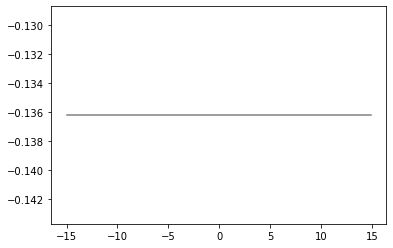

In [24]:
fn = create_constant(random.uniform(-10,10))
qscale = 16
lr = 1e-2
lsize = 8
qsize = 4

# fn = create_linear(random.uniform(-10,10), random.uniform(-10,10))
# qscale = 32
# lr = 1e-2
# lsize = 8
# qsize = 4

# fn = create_quadratic(random.uniform(-10,10), random.uniform(-10,10), random.uniform(-10,10))
# qscale = 16
# lr = 5e-4
# lsize = 16
# qsize = 1

# fn = create_cubic(random.uniform(-10,10), random.uniform(-10,10), random.uniform(-10,10), random.uniform(-10,10))
# qscale = 4
# lr = 1e-4
# lsize = 64
# qsize = 16

# fn = create_quartic(random.uniform(-1,1), random.uniform(-1,1), random.uniform(-1,1), random.uniform(-1,1), random.uniform(-1,1))
# qscale = 4
# lr = 1e-4
# lsize = 256
# qsize = 16


train_data = SimpleFunctionDataset(x=random_x(1000, -5, 5), fn=fn) # 1000 training examples
test_data = SimpleFunctionDataset(x=random_x(100), fn=fn)   #  100 testing examples
# do we need separate training and testing data for simple generated data like this?
# probably... we need to make sure the quadratics don't overfit

x = np.arange(-15, 15, 0.1)
y = np.array([fn(xi) for xi in x])

plt.rcParams['figure.figsize'] = [6.0, 4.0]
plt.plot(x, y, label="Fn", linewidth=1.5, color="Gray")

In [25]:
nnl = SimpleLinearModel(lsize).to(device)
nnq = SimpleQuadraticModel(qsize, qscale).to(device)
nnl = nnl.to(device)
nnq = nnq.to(device)

trainer = LQTrainer(nnl, nnq, lr=lr)

lr = 0.01


In [32]:
# train_data = SimpleFunctionDataset(x=random_x(1), fn=fn) # 1000 training examples
# trainer.print_params()
trainer.plot_every = 500
trainer.train(10000, train_data)
# trainer.print_params()

Epoch: 500 L Loss: 1.7199065041495487e-05 Q Loss: 5.570497705775779e-06
Epoch: 1000 L Loss: 1.6772937669884413e-05 Q Loss: 5.549944489757763e-06
Epoch: 1500 L Loss: 1.6389323718613014e-05 Q Loss: 5.542301551031414e-06
Epoch: 2000 L Loss: 1.6077847249107435e-05 Q Loss: 5.536435310204979e-06
Epoch: 2500 L Loss: 1.5756837456137873e-05 Q Loss: 5.541114660445601e-06
Epoch: 3000 L Loss: 1.544021324662026e-05 Q Loss: 5.517679710465018e-06
Epoch: 3500 L Loss: 1.5143209566303995e-05 Q Loss: 5.494400738825789e-06
Epoch: 4000 L Loss: 1.4809375898039434e-05 Q Loss: 5.49752030565287e-06
Epoch: 4500 L Loss: 1.45025906022056e-05 Q Loss: 5.486965619638795e-06
Epoch: 5000 L Loss: 1.4237652976589743e-05 Q Loss: 5.4645179261569865e-06
Epoch: 5500 L Loss: 1.3986884368932806e-05 Q Loss: 5.451788183563622e-06
Epoch: 6000 L Loss: 1.3656755982083268e-05 Q Loss: 5.433670139609603e-06
Epoch: 6500 L Loss: 1.338580568699399e-05 Q Loss: 5.4248735068540554e-06
Epoch: 7000 L Loss: 1.3131258128851186e-05 Q Loss: 5.43

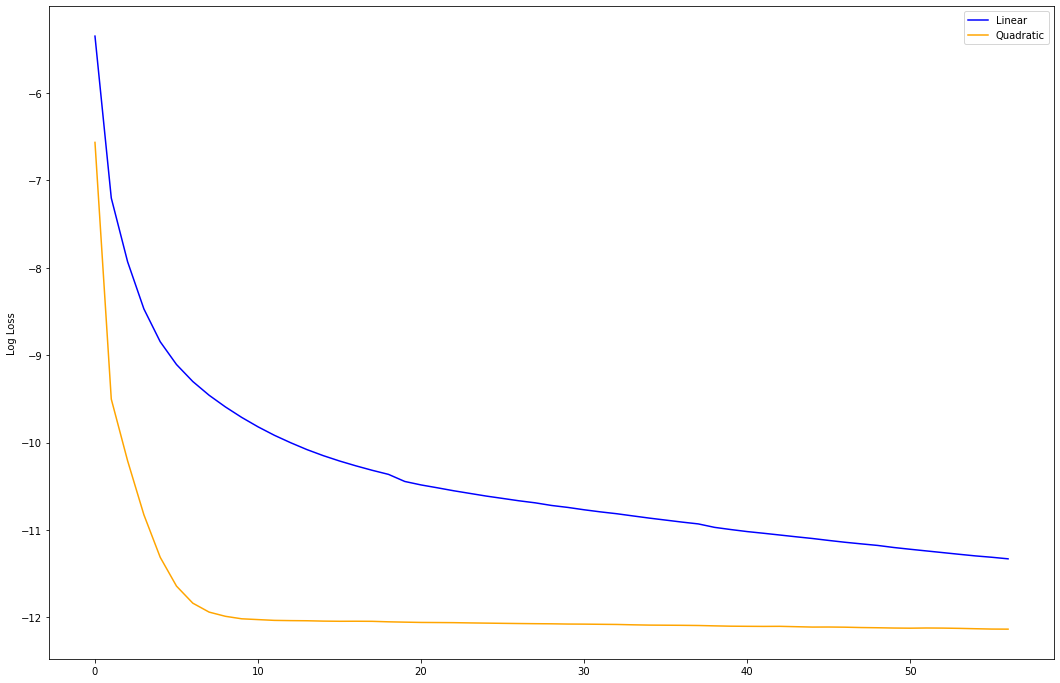

In [33]:
trainer.plot_error()

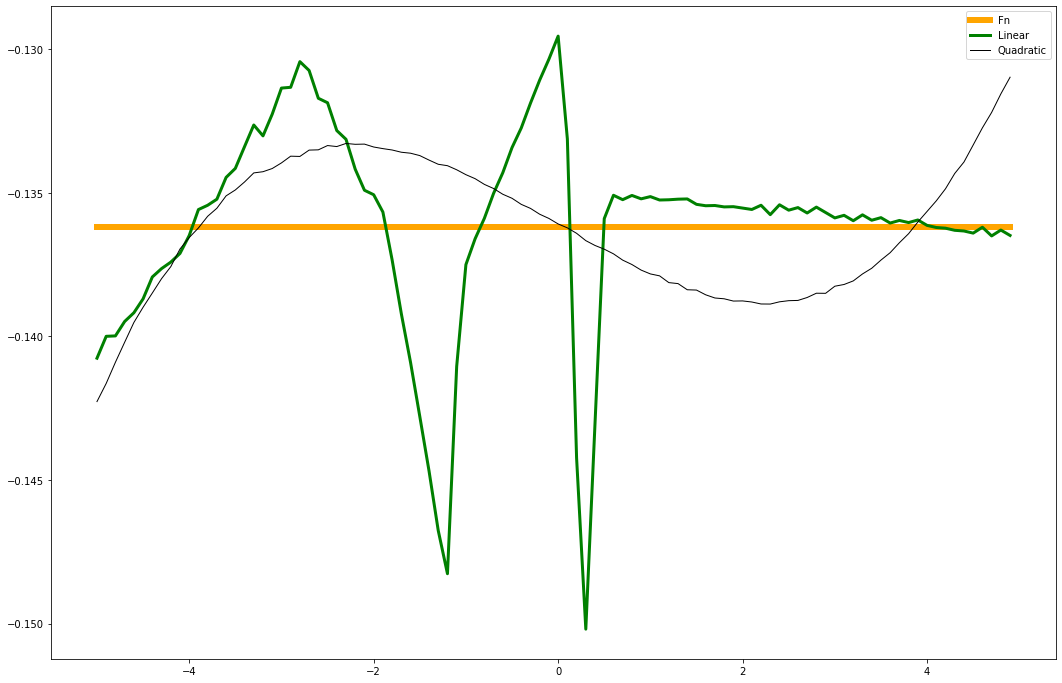

In [34]:
plt.rcParams['figure.figsize'] = [18.0, 12.0]

x = np.arange(-5, 5, 0.1)
y = np.array([fn(xi) for xi in x])
x_ten = torch.tensor(list(map(lambda xi: [xi], x)), dtype=torch.float).to(device)
y_lin = nnl.forward(x_ten).tolist()
y_qua = nnq.forward(x_ten).tolist()

plt.plot(x, y, label="Fn", linewidth=6, color="Orange")
plt.plot(x, y_lin, label="Linear", linewidth=3, color="Green")
plt.plot(x, y_qua, label="Quadratic", linewidth=1, color="Black")

plt.legend()